In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision import datasets
from torchvision import transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3072, 10)
        self.fc2 = nn.Linear(10, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## SGLD optimizer

In [4]:
class SGLD(optim.SGD):
    def __init__(self, params, lr=1e-3):
        super(SGLD, self).__init__(params, lr=lr)
        

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if d_p.is_sparse:
                    raise RuntimeError('SGLD does not support sparse gradients')
                
                noise = torch.randn_like(p) * torch.sqrt(torch.tensor(group['lr'] * 0.2 ))
                p.data.add_(-group['lr'], d_p + noise)

        return loss

## Irr optimizer


In [5]:
def create_antisymmetric_matrix(dim):
    matrix = np.array([[0] * dim for _ in range(dim)])
    for i in range(dim):
        for j in range(i + 1, dim):
            matrix[i][j] =  1
            matrix[j][i] = -matrix[i][j]
    return matrix

matrix_np = create_antisymmetric_matrix(10)
A = torch.from_numpy(matrix_np)
print(A.size())
I= torch.eye(10)  


torch.Size([10, 10])


In [6]:
class IrrOptim(optim.SGD):
    def __init__(self, params, lr=1e-3, temperature=1.0):
        super(IrrOptim, self).__init__(params, lr=lr)
        self.temperature = temperature


    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if d_p.is_sparse:
                    raise RuntimeError('SGLD does not support sparse gradients')
                
                noise = torch.randn_like(p) * torch.sqrt(torch.tensor(group['lr'] * 0.05 ))
                #print(A.size())
                #print(d_p.size())
                #A即为反对称矩阵
                d_p = torch.matmul(torch.add(I, self.temperature*A).to(device), d_p)
                
                p.data.add_(-group['lr'], d_p + noise)

        return loss

## Experiment on Mnist

In [7]:
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

In [8]:
EPOCHS=30
BATCH_SIZE=128
Trans = transforms.Compose([
    transforms.ToTensor(),#从numpy转成tensor,在GPU上跑
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = datasets.CIFAR10("data",train=True,download=True,transform=Trans)
test_set = datasets.CIFAR10("data",train=False,download=True,transform=Trans)
train_loader = DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
def Output(model, image, target): 
    criterion = nn.CrossEntropyLoss()
    output = model(image)
    loss=criterion(output,target)
    return output, loss

In [10]:
def test(model,optimizer,scheduler):
    Train_loss=[]
    Train_accuracy=[]
    for epoch in range(EPOCHS):
        running_cls_loss = 0.0
        running_cls_corrects = 0
        for batch_idx, (image, target) in enumerate(train_loader):
            image = image.to(device)
            target = target.to(device)
            outputs, loss = Output(model, image, target)
            _, preds = torch.max(outputs, 1) 
            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        scheduler.step()
        epoch_loss = running_cls_loss*BATCH_SIZE / len(train_set)
        Train_loss.append(epoch_loss)
        epoch_acc = running_cls_corrects.double() / len(train_set)
        Train_accuracy.append(epoch_acc)

        
        if  (epoch +1) == EPOCHS:
            model.eval()
            val_loss = 0.0
            val_corrects = 0
            for batch_idx, (image, target) in enumerate(test_loader):
                image = image.to(device)
                target = target.to(device)
                outputs, loss = Output(model, image, target)
                _, preds = torch.max(outputs, 1)  
                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)    
            
            val_acc = val_corrects.double() / len(test_set)
    return Train_loss,Train_accuracy,val_acc

In [11]:
model1 = Net()
model1.to(device)
sgld=SGLD(model1.parameters(), lr=0.01)
sgldscheduler = torch.optim.lr_scheduler.StepLR(sgld, step_size=STEP, gamma=GAMMA)
resgld=test(model1,sgld,sgldscheduler)
Sgld_Train_Loss=resgld[0]
Sgld_Train_Accuracy=resgld[1]

print("Accuracy for SGLD in CIFAR10:",format(resgld[2]*100, '.2f'),"%")

/tmp/ipykernel_20221/649160487.py:20: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1533.)
  p.data.add_(-group['lr'], d_p + noise)


Accuracy for SGLD in CIFAR10: 40.83 %


In [ ]:
result={}
for i in range(1,4):
    model = Net()
    model.to(device)
    irr=IrrOptim(model.parameters(), lr=0.01, temperature=i*0.5)
    irrscheduler = torch.optim.lr_scheduler.StepLR(irr, step_size=STEP, gamma=GAMMA)
    reIrr=test(model,irr,irrscheduler)
    result[i]=reIrr

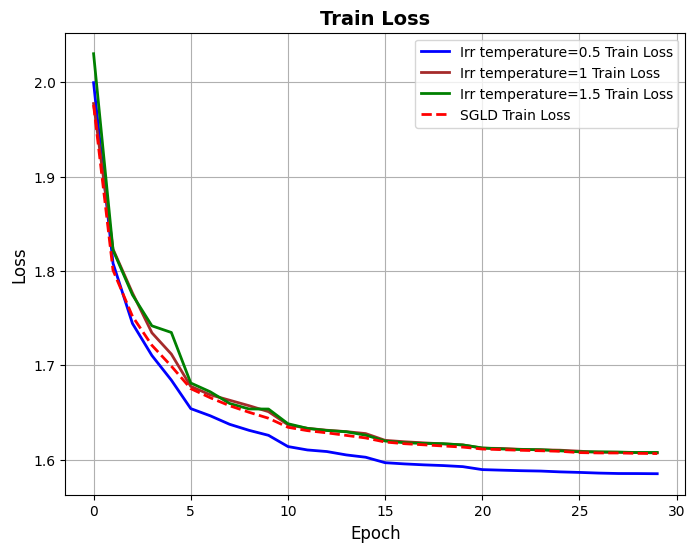

In [15]:
plt.figure(figsize=(8, 6))  
plt.plot(result.get(1)[0],label=f"Irr temperature={0.5} Train Loss", linestyle='-', linewidth=2.0, color='blue')
plt.plot(result.get(2)[0],label=f"Irr temperature={1} Train Loss", linestyle='-', linewidth=2.0, color='brown')
plt.plot(result.get(3)[0],label=f"Irr temperature={1.5} Train Loss", linestyle='-', linewidth=2.0, color='green')
#plt.plot(result.get(4)[0],label=f"Irr temperature={2} Train Loss", linestyle='-', linewidth=2.0, color='orange')
#plt.plot(result.get(5)[0],label=f"Irr temperature={2.5} Train Loss", linestyle='-', linewidth=2.0, color='gray')
plt.plot(Sgld_Train_Loss, label="SGLD Train Loss", linestyle='--', linewidth=2.0, color='red')
plt.xlabel('Epoch', fontsize=12)  
plt.ylabel('Loss', fontsize=12) 
plt.title('Train Loss', fontsize=14, fontweight='bold') 
plt.grid(True)
plt.legend(fontsize=10) 
plt.show()

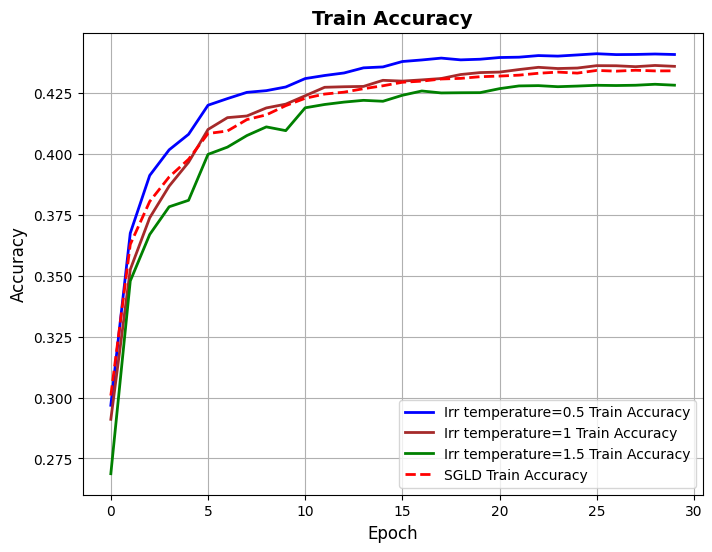

In [14]:
plt.figure(figsize=(8, 6))
plt.plot([tensor.item() for tensor in result.get(1)[1]],label=f"Irr temperature={0.5} Train Accuracy", linestyle='-', linewidth=2.0, color='blue')
plt.plot([tensor.item() for tensor in result.get(2)[1]],label=f"Irr temperature={1} Train Accuracy", linestyle='-', linewidth=2.0, color='brown')
plt.plot([tensor.item() for tensor in result.get(3)[1]],label=f"Irr temperature={1.5} Train Accuracy", linestyle='-', linewidth=2.0, color='green')
plt.plot([tensor.item() for tensor in Sgld_Train_Accuracy], label="SGLD Train Accuracy", linestyle='--', linewidth=2.0, color='red')
plt.xlabel('Epoch', fontsize=12)  
plt.ylabel('Accuracy', fontsize=12) 
plt.title('Train Accuracy', fontsize=14, fontweight='bold') 
plt.grid(True)
plt.legend(fontsize=10) 
plt.show()